In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

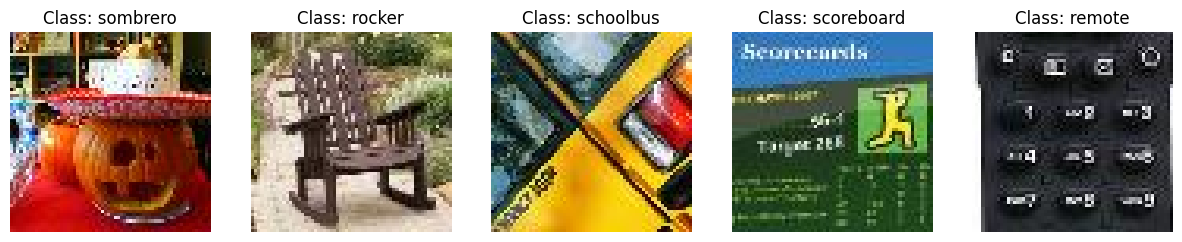

In [ ]:
sample_images = []
unique_labels = []
labels = []
drive_path = "/content/drive/MyDrive/Group_6/train"

for class_name in os.listdir(drive_path):
    if os.path.isdir(os.path.join(drive_path, class_name)):
        unique_labels.append(class_name)

fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 3))
for i, class_name in enumerate(unique_labels):
    class_path = os.path.join(drive_path, class_name)
    image_files = os.listdir(class_path)

    if not image_files:
        continue

    sample_image_path = os.path.join(class_path, image_files[0])
    sample_images.append(sample_image_path)

    labels.extend([class_name] * len(image_files))

    image = Image.open(sample_image_path)
    axes[i].imshow(image)
    axes[i].set_title(f'Class: {class_name}')
    axes[i].axis('off')

plt.show()

Class: sombrero, Number of Samples: 2000
Class: rocker, Number of Samples: 2000
Class: schoolbus, Number of Samples: 2000
Class: scoreboard, Number of Samples: 2000
Class: remote, Number of Samples: 2000


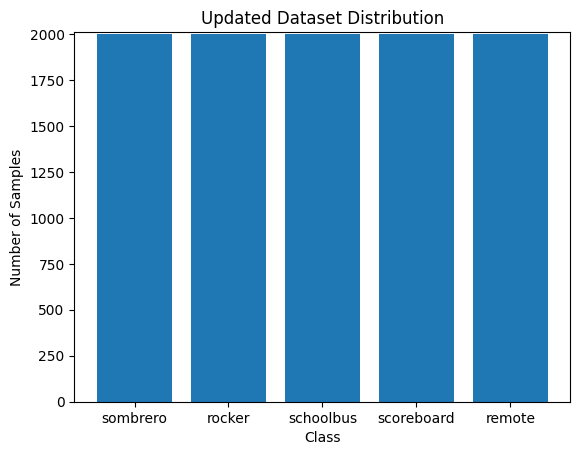

The dataset distribution is unbalanced.


In [ ]:
drive_path = "/content/drive/MyDrive/Group_6/train"
class_names = os.listdir(drive_path)

target_samples = 2000

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


for class_name in class_names:
    class_dir = os.path.join(drive_path, class_name)
    num_samples = len(os.listdir(class_dir))


    if num_samples < target_samples:
        num_new_samples = target_samples - num_samples


        images = []
        for filename in os.listdir(class_dir):
            image = Image.open(os.path.join(class_dir, filename))
            image = image.convert('RGB')
            image = np.array(image)
            images.append(image)
        images = np.array(images)


        i = 0
        for batch in datagen.flow(images, batch_size=1, save_to_dir=class_dir, save_prefix='aug', save_format='jpeg'):
            i += 1
            if i >= num_new_samples:
                break


labels = []
for class_name in class_names:
    class_dir = os.path.join(drive_path, class_name)
    num_samples = len(os.listdir(class_dir))
    labels.extend([class_name] * num_samples)

class_counts = Counter(labels)


for class_name, count in class_counts.items():
    print(f'Class: {class_name}, Number of Samples: {count}')


plt.bar(class_names, class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Updated Dataset Distribution')
plt.ylim(bottom=0, top=max(class_counts.values()) + 10)
plt.show()


if len(set(class_counts.values())) == len(class_counts.values()):
    print("The dataset distribution is balanced.")
else:
    print("The dataset distribution is unbalanced.")

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    drive_path,
    target_size=(227, 227),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    drive_path,
    target_size=(227, 227),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 8000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(96, kernel_size=(11,11), strides=4, padding='valid', activation='relu', input_shape=(227, 227, 3), kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

model.add(Conv2D(256, kernel_size=(5,5), strides=1, padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

model.add(Conv2D(384, kernel_size=(3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(Conv2D(384, kernel_size=(3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(Conv2D(256, kernel_size=(3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(Dense(len(class_names), activation='softmax'))

In [ ]:
checkpoint = ModelCheckpoint('best_model.h5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto')



model.compile(optimizer=Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 384)       885120    
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 384)      

In [ ]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator,
                    callbacks=[checkpoint])




Epoch 1/15
250/250 [==============================] - ETA: 0s - loss: 1.9047 - accuracy: 0.2007
Epoch 1: val_loss improved from inf to 1.60950, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 42s 152ms/step - loss: 1.9047 - accuracy: 0.2007 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 2/15
250/250 [==============================] - ETA: 0s - loss: 1.6100 - accuracy: 0.1978
Epoch 2: val_loss improved from 1.60950 to 1.60947, saving model to best_model.h5
250/250 [==============================] - 32s 126ms/step - loss: 1.6100 - accuracy: 0.1978 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 3/15
250/250 [==============================] - ETA: 0s - loss: 1.6100 - accuracy: 0.1956
Epoch 3: val_loss did not improve from 1.60947
250/250 [==============================] - 29s 114ms/step - loss: 1.6100 - accuracy: 0.1956 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 4/15
250/250 [==============================] - ETA: 0s - loss: 1.6098 - accuracy: 0.1965
Epoch 4: val_loss improved from 1.60947 to 1.60947, saving model to best_model.h5
250/250 [==============================] - 37s 149ms/step - loss: 1.6098 - accuracy: 0.1965 - val_l

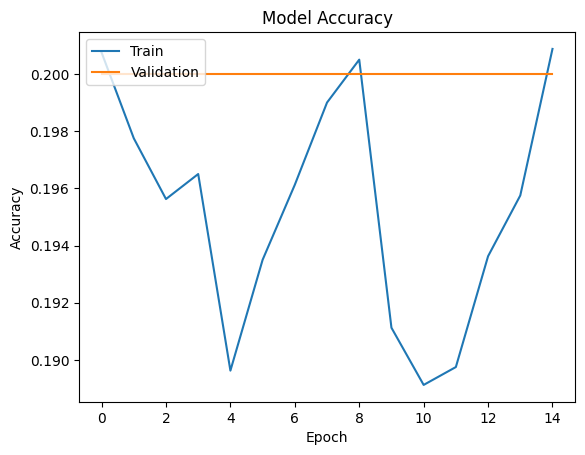

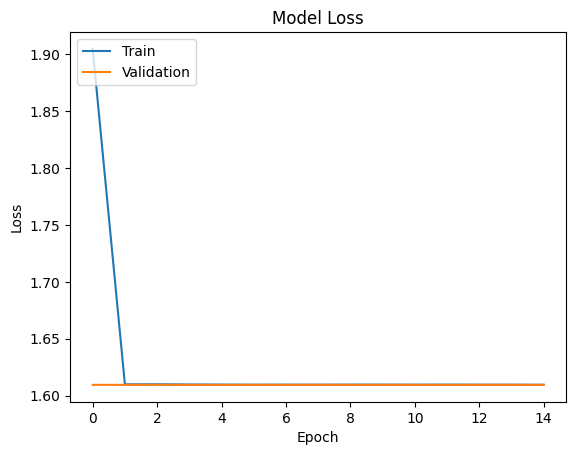

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
best_model = load_model('best_model.h5')

train_eval_result = best_model.evaluate(train_generator)
print("Training Loss:", train_eval_result[0])
print("Training Accuracy:", train_eval_result[1])


test_path = "/content/drive/MyDrive/Group_6/test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(227, 227),
    batch_size=32,
    class_mode='categorical'
)

test_eval_result = best_model.evaluate(test_generator)
print("Test Loss:", test_eval_result[0])
print("Test Accuracy:", test_eval_result[1])


250/250 [==============================] - 21s 81ms/step - loss: 1.6094 - accuracy: 0.2000
Training Loss: 1.6094412803649902
Training Accuracy: 0.20000000298023224
Found 250 images belonging to 5 classes.
8/8 [==============================] - 1s 176ms/step - loss: 1.6094 - accuracy: 0.2000
Test Loss: 1.6094406843185425
Test Accuracy: 0.20000000298023224


8/8 [==============================] - 1s 81ms/step
Actual Label: 0, Predicted Label: 2


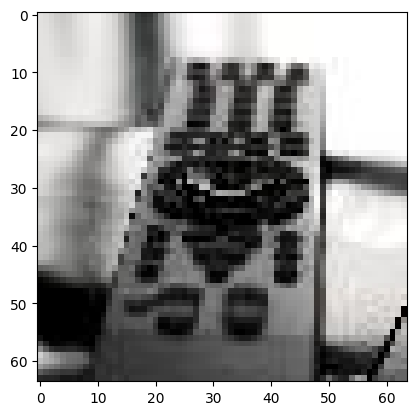

Actual Label: 0, Predicted Label: 2


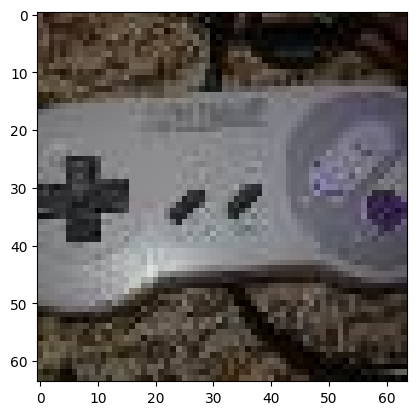

Actual Label: 0, Predicted Label: 2


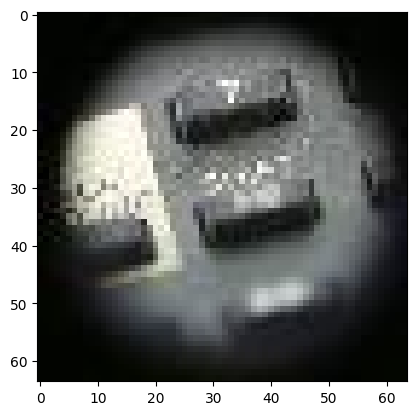

Actual Label: 0, Predicted Label: 2


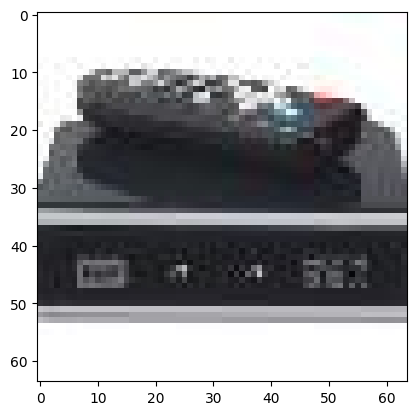

Actual Label: 0, Predicted Label: 2


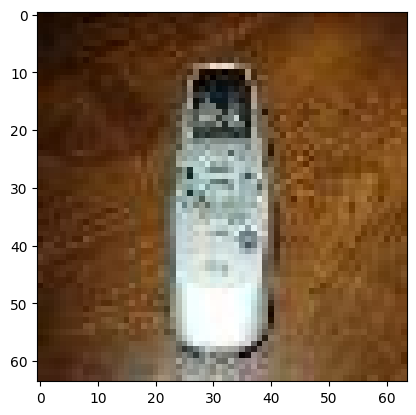

In [ ]:
predictions = best_model.predict(test_generator)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes


misclassified_indices = np.where(predicted_labels != true_labels)[0]

num_misclassified_to_show = 5
for i in range(num_misclassified_to_show):
    misclassified_index = misclassified_indices[i]
    misclassified_image = test_generator.filepaths[misclassified_index]
    actual_label = test_generator.classes[misclassified_index]
    predicted_label = predicted_labels[misclassified_index]


    print(f"Actual Label: {actual_label}, Predicted Label: {predicted_label}")
    image = plt.imread(misclassified_image)
    plt.imshow(image)
    plt.show()


In [ ]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50

def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides=(s, s), name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(F2, (f, f), strides=(1, 1), name=conv_name_base + '2b', padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), strides=(1, 1), name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape=(64, 64, 3), classes=5):
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model




In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_generator = datagen.flow_from_directory(
    drive_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)


validation_generator = datagen.flow_from_directory(
    drive_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 8000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.


In [ ]:
model = ResNet50(input_shape=(64, 64, 3), classes=5)

checkpoint = ModelCheckpoint('best_model1.h5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto')

model.compile(optimizer=Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 70, 70, 3)            0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1 (Conv2D)              (None, 32, 32, 64)           9472      ['zero_padding2d_2[0][0]']    
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1[0][0]']        

In [ ]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator,
                    callbacks=[checkpoint])

Epoch 1/15
250/250 [==============================] - ETA: 0s - loss: 1.8484 - accuracy: 0.4115
Epoch 1: val_loss improved from inf to 2.94700, saving model to best_model1.h5
250/250 [==============================] - 65s 135ms/step - loss: 1.8484 - accuracy: 0.4115 - val_loss: 2.9470 - val_accuracy: 0.2000
Epoch 2/15
250/250 [==============================] - ETA: 0s - loss: 1.5410 - accuracy: 0.4793
Epoch 2: val_loss did not improve from 2.94700
250/250 [==============================] - 26s 103ms/step - loss: 1.5410 - accuracy: 0.4793 - val_loss: 133.9471 - val_accuracy: 0.2255
Epoch 3/15
250/250 [==============================] - ETA: 0s - loss: 1.3755 - accuracy: 0.5245
Epoch 3: val_loss did not improve from 2.94700
250/250 [==============================] - 25s 98ms/step - loss: 1.3755 - accuracy: 0.5245 - val_loss: 3.1757 - val_accuracy: 0.4500
Epoch 4/15
250/250 [==============================] - ETA: 0s - loss: 1.0392 - accuracy: 0.6181
Epoch 4: val_loss did not improve from 2

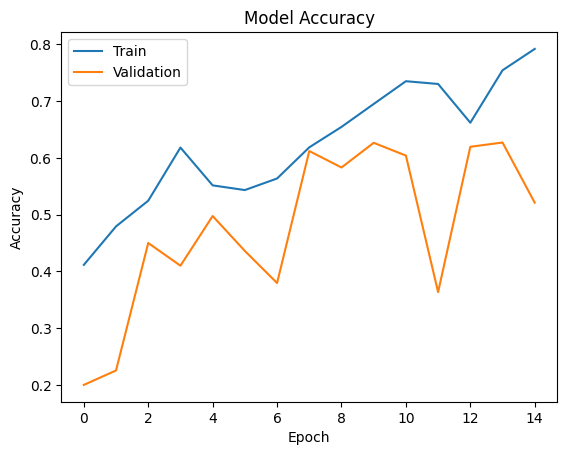

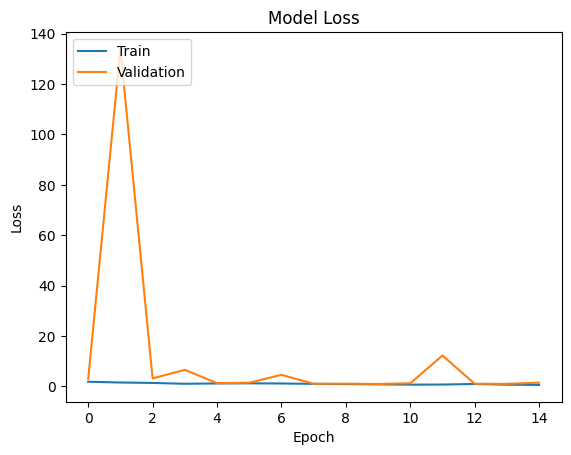

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
best_model1 = load_model('best_model1.h5')

train_eval_result = best_model1.evaluate(train_generator)
print("Training Loss:", train_eval_result[0])
print("Training Accuracy:", train_eval_result[1])


test_path = "/content/drive/MyDrive/Group_6/test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

test_eval_result = best_model1.evaluate(test_generator)
print("Test Loss:", test_eval_result[0])
print("Test Accuracy:", test_eval_result[1])


250/250 [==============================] - 16s 58ms/step - loss: 0.6817 - accuracy: 0.7439
Training Loss: 0.6816564798355103
Training Accuracy: 0.7438750267028809
Found 250 images belonging to 5 classes.
8/8 [==============================] - 1s 170ms/step - loss: 0.8687 - accuracy: 0.7040
Test Loss: 0.8686838746070862
Test Accuracy: 0.7039999961853027


8/8 [==============================] - 2s 60ms/step
Actual Label: 0, Predicted Label: 3


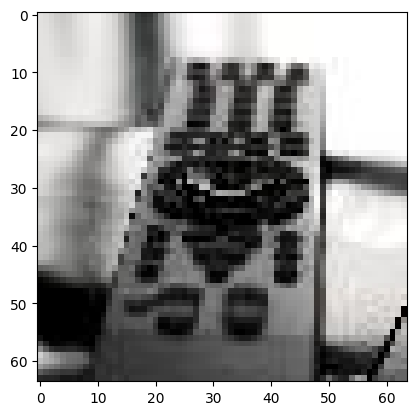

Actual Label: 0, Predicted Label: 1


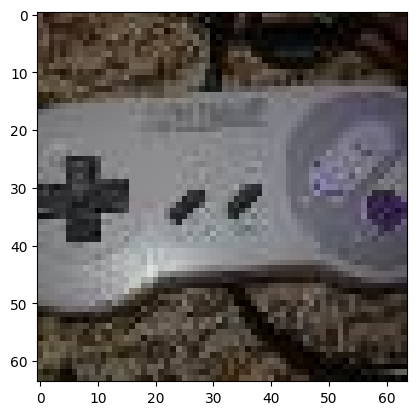

Actual Label: 0, Predicted Label: 1


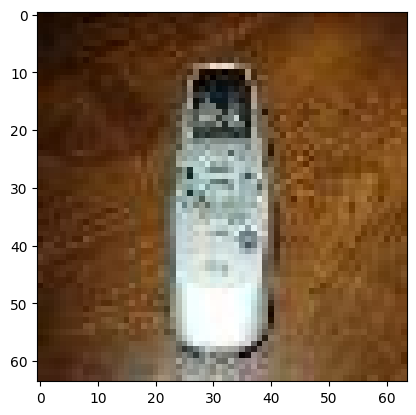

Actual Label: 0, Predicted Label: 2


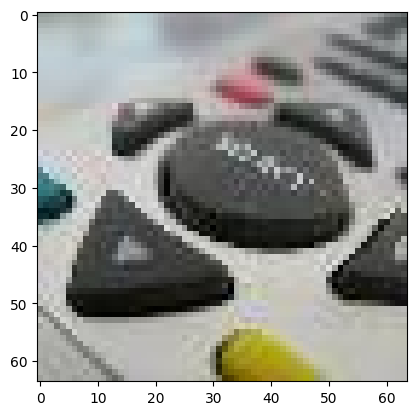

Actual Label: 0, Predicted Label: 1


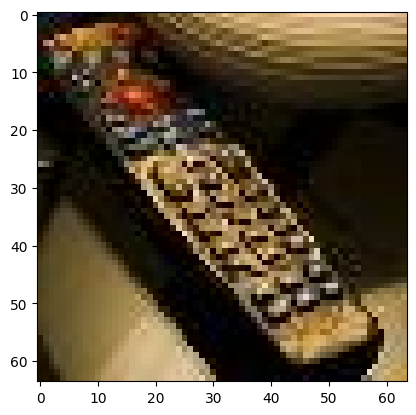

In [ ]:
predictions = best_model1.predict(test_generator)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes


misclassified_indices = np.where(predicted_labels != true_labels)[0]

num_misclassified_to_show = 5
for i in range(num_misclassified_to_show):
    misclassified_index = misclassified_indices[i]
    misclassified_image = test_generator.filepaths[misclassified_index]
    actual_label = test_generator.classes[misclassified_index]
    predicted_label = predicted_labels[misclassified_index]


    print(f"Actual Label: {actual_label}, Predicted Label: {predicted_label}")
    image = plt.imread(misclassified_image)
    plt.imshow(image)
    plt.show()


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_model = InceptionV3(weights='imagenet', include_top=False)


x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)



predictions = Dense(5, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)


for layer in base_model.layers:
    layer.trainable = False

checkpoint = ModelCheckpoint('best_model2.h5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto')

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  #


train_generator = datagen.flow_from_directory(
    drive_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    drive_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation')


history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator,
                    callbacks=[checkpoint])

Found 8000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.
Epoch 1/15
250/250 [==============================] - ETA: 0s - loss: 1.1263 - accuracy: 0.7911
Epoch 1: val_loss improved from inf to 0.48879, saving model to best_model2.h5
250/250 [==============================] - 63s 119ms/step - loss: 1.1263 - accuracy: 0.7911 - val_loss: 0.4888 - val_accuracy: 0.8205
Epoch 2/15
250/250 [==============================] - ETA: 0s - loss: 0.3583 - accuracy: 0.8795
Epoch 2: val_loss did not improve from 0.48879
250/250 [==============================] - 23s 92ms/step - loss: 0.3583 - accuracy: 0.8795 - val_loss: 0.6292 - val_accuracy: 0.8135
Epoch 3/15
250/250 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 0.9059
Epoch 3: val_loss did not improve from 0.48879
250/250 [==============================] - 22s 90ms/step - loss: 0.2758 - accuracy: 0.9059 - val_loss: 0.5171 - val_accuracy: 0.8370
Epoch 4/15
250/250 [==============================] - E

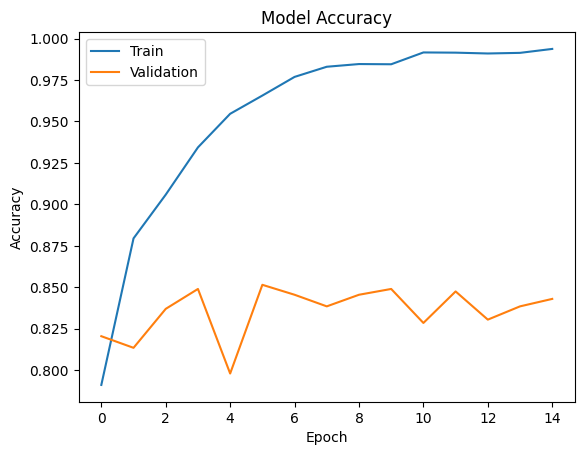

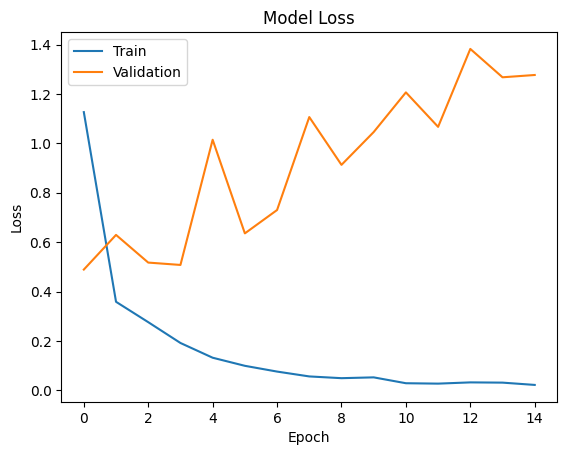

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
best_model2 = load_model('best_model2.h5')

train_eval_result = best_model2.evaluate(train_generator)
print("Training Loss:", train_eval_result[0])
print("Training Accuracy:", train_eval_result[1])


test_path = "/content/drive/MyDrive/Group_6/test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_eval_result = best_model2.evaluate(test_generator)
print("Test Loss:", test_eval_result[0])
print("Test Accuracy:", test_eval_result[1])


250/250 [==============================] - 20s 71ms/step - loss: 0.3070 - accuracy: 0.8917
Training Loss: 0.30695006251335144
Training Accuracy: 0.8917499780654907
Found 250 images belonging to 5 classes.
8/8 [==============================] - 2s 325ms/step - loss: 0.3155 - accuracy: 0.8920
Test Loss: 0.31549665331840515
Test Accuracy: 0.8920000195503235


8/8 [==============================] - 2s 69ms/step
Actual Label: 0, Predicted Label: 4


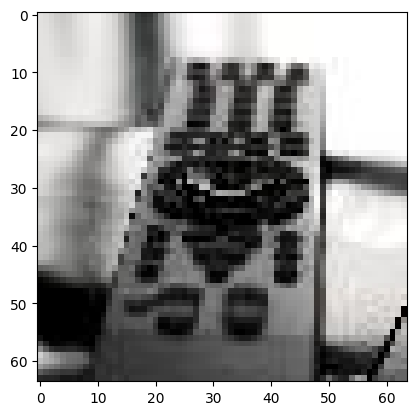

Actual Label: 0, Predicted Label: 3


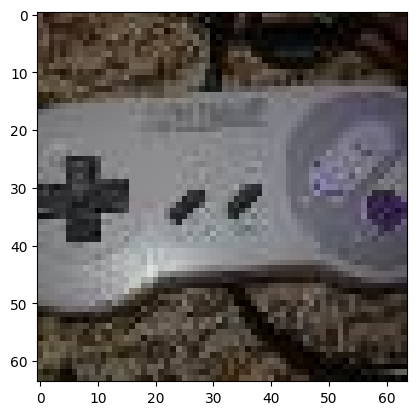

Actual Label: 0, Predicted Label: 1


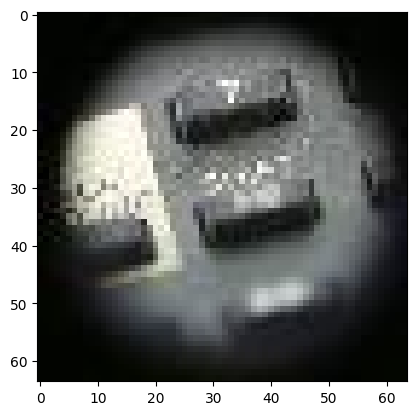

Actual Label: 0, Predicted Label: 2


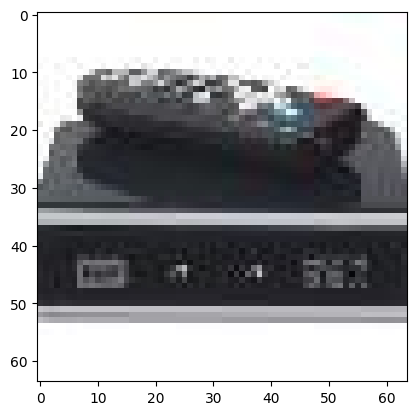

Actual Label: 0, Predicted Label: 4


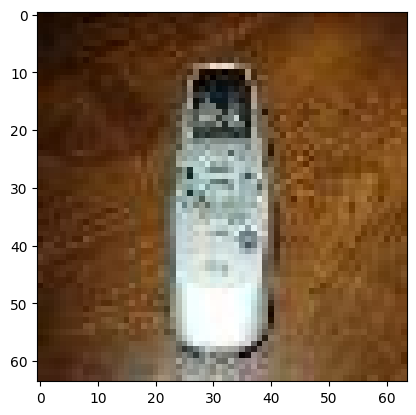

In [ ]:
predictions = best_model2.predict(test_generator)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes


misclassified_indices = np.where(predicted_labels != true_labels)[0]

num_misclassified_to_show = 5
for i in range(num_misclassified_to_show):
    misclassified_index = misclassified_indices[i]
    misclassified_image = test_generator.filepaths[misclassified_index]
    actual_label = test_generator.classes[misclassified_index]
    predicted_label = predicted_labels[misclassified_index]


    print(f"Actual Label: {actual_label}, Predicted Label: {predicted_label}")
    image = plt.imread(misclassified_image)
    plt.imshow(image)
    plt.show()


In [ ]:
model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))


model.add(Flatten())


model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(len(class_names), activation='softmax'))  # Adjust the number of output classes if necessary

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  #


train_generator = datagen.flow_from_directory(
    drive_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    drive_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation')




checkpoint = ModelCheckpoint('best_model3.h5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()


history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator,
                    callbacks=[checkpoint])

Found 8000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 128)       73856     
                                    

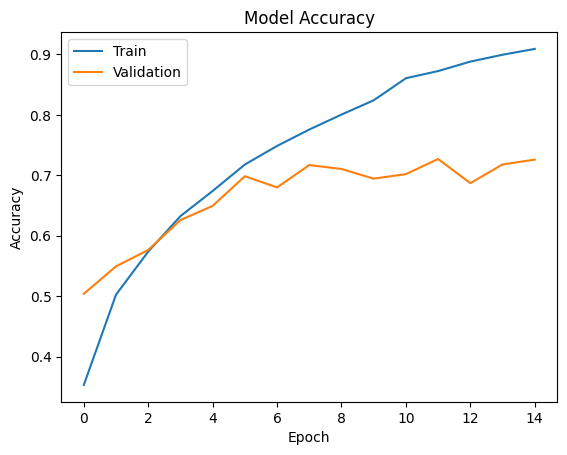

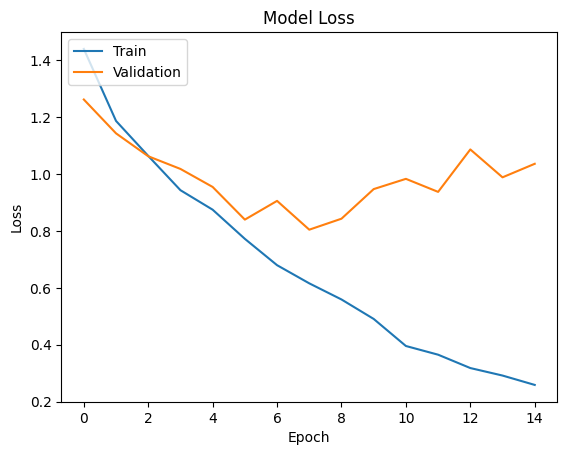

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
best_model3 = load_model('best_model3.h5')

train_eval_result = best_model3.evaluate(train_generator)
print("Training Loss:", train_eval_result[0])
print("Training Accuracy:", train_eval_result[1])


test_path = "/content/drive/MyDrive/Group_6/test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

test_eval_result = best_model3.evaluate(test_generator)
print("Test Loss:", test_eval_result[0])
print("Test Accuracy:", test_eval_result[1])


250/250 [==============================] - 14s 55ms/step - loss: 0.3954 - accuracy: 0.8583
Training Loss: 0.3953990638256073
Training Accuracy: 0.8582500219345093
Found 250 images belonging to 5 classes.
8/8 [==============================] - 1s 51ms/step - loss: 0.7027 - accuracy: 0.7600
Test Loss: 0.7026858329772949
Test Accuracy: 0.7599999904632568
